In [1]:
%autosave 15
%matplotlib inline

import numpy as np
import scipy as sp
import scipy.optimize as sopt
import pandas as pd
import math
import random

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from IPython.display import display, HTML

Autosaving every 15 seconds


In [28]:
def printAllPoints(data, classes):
    green = [[], []]
    blue = [[], []]
    for (x, y) in data:
        if (classes[(x, y)] == 0):
            green[0].append(x)
            green[1].append(y)
        else:
            blue[0].append(x)
            blue[1].append(y)
    plt.plot(green[0], green[1], 'g.', blue[0], blue[1], 'b.')

In [29]:
def get_data(transform, name):
    fin = open('chips.txt', 'r')
    lines = fin.readlines()
    fin.close()
    
    classes = dict()
    data = list()
    
    for x, y, z in [map(float, x.split(',')) for x in lines]:
        a, b = transform(x, y)
        data.append((a, b))
        classes[(a, b)] = z
    
    return (data, classes, name, transform)

In [30]:
def toPolar(x, y, x0, y0):
    x, y = x - x0, y - y0
    r = (x ** 2 + y ** 2) ** (1 / 2)
    a = math.atan2(x, y)
    return (r, a)

def getCenter():
    fin = open('chips.txt', 'r')
    lines = fin.readlines()
    fin.close()

    x0, y0 = 0, 0
    for x, y, z in [map(float, x.split(',')) for x in lines]:
        x0 += x
        y0 += y
    x0 = x0 / len(lines)
    y0 = y0 / len(lines)
    
    return (x0, y0)

In [31]:
simpleData = get_data(lambda x, y:(x, y), '-')
sumData = get_data(lambda x, y:(x, x + y), 'x, y -> x, x + y')
polarData = get_data(lambda x, y: toPolar(x, y, 0, 0), 'polar(0, 0)')

center = getCenter()
polarData2 = get_data(lambda x, y: toPolar(x, y, center[0], center[1]), 'polar(center_x, center_y)')

wideData = get_data(lambda x, y: ( toPolar(x, y, center[0], center[1])[0] * 10 
                                 , toPolar(x, y, center[0], center[1])[0] + toPolar(x, y, center[0], center[1])[1]
                                 )
                    , 'wide')


data = [simpleData, sumData, polarData, polarData2, wideData]

In [32]:
#printAllPoints(wideData[0], wideData[1])

In [33]:
#printAllPoints(simpleData[0], simpleData[1])

In [34]:
#printAllPoints(sumData[0], sumData[1])

In [35]:
#printAllPoints(polarData[0], polarData[1])

In [36]:
#printAllPoints(polarData2[0], polarData2[1])

In [11]:
def minkowskiDistance(x, y, p):
    res = 0
    for i in range(len(x)):
        res += abs(x[i] - y[i]) ** p
    return res ** (1 / p)

# https://en.wikipedia.org/wiki/Cosine_similarity
def cosineSimilarity(x, y):
    res, a, b = 0, 0, 0
    for i in range(len(x)):
        res += x[i] * y[i]
        a += x[i] ** 2
        b += y[i] ** 2
    a = a ** (1 / 2)
    b = b ** (1 / 2)
    return res / a / b
    

metrics = [lambda x, y: minkowskiDistance(x, y, 1), 
           lambda x, y: minkowskiDistance(x, y, 2)
          ]
#lambda x, y: cosineSimilarity(x, y)]    

metric_names = dict()
metric_names[metrics[0]] = 'minkowski with p = 1'
metric_names[metrics[1]] = 'minkowski with p = 2'
#metric_names[metrics[2]] = 'cosine'

#for metric in metrics:
#    print(metric((1, 1), (2, 2)))

In [ ]:
kernels = [
    (lambda x: 1 / 2, 'uniform'),
    (lambda x: 1 - abs(x), 'triangular'),
    (lambda x: 3 / 4 * (1 - x * x), 'parabolic'),
    (lambda x: (1 - x ** 2) ** 2 * 15 / 16, 'quartic')
]

In [12]:
def k_fold_cv(k, length):
    one_fold_length = length // k
    others = length % k
    indexies = [i for i in range(length)]
    result = list()
    for i in range(k):
        test_suit = list()
        train_suit = list()

        for j in range(one_fold_length):
            index = indexies[int(np.random.uniform(0, len(indexies))) % len(indexies)]
            test_suit.append(index)
            indexies.remove(index)
        if others > 0:
            others -= 1
            index = indexies[int(np.random.uniform(0, len(indexies))) % len(indexies)]
            test_suit.append(index)
            indexies.remove(index)
        
        for j in range(length):
            if j not in test_suit:
                train_suit.append(j)
        
        result.append((train_suit, test_suit))
    return result

In [16]:
results = pd.DataFrame(columns=['k', 'metric', 'accuracy'])


best_accuracy = 0
best_kernel   = None
best_metric   = None
best_data     = None
best_neighbor = None
best_kfold = None

pd.set_option('display.height', 250)
pd.set_option('display.max_rows', 250)

for kfold in range(5, 11):
    for kernel in kernels:
        for metric in metrics:
            for input_data, classes, transform_name, transform in data:
                k, accuracy = (kNN(metric, input_data, classes, kernel[0], (1, kfold)))
                raw = pd.DataFrame([[kfold, k, metric_names[metric], transform_name, accuracy, kernel[1]]], columns=['folds', 'k', 'metric', 'transformation name', 'accuracy', 'kernel'])
                results = results.append(raw, ignore_index=True)
            
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_kernel = kernel[0]
                    best_metric = metric
                    best_data = (input_data, classes, transform)
                    best_neighbor = k
                    best_kfold = kfold
                
                    best_string = str(accuracy) + ', ' + str(k) + ', ' + kernel[1] + ', ' + metric_names[metric] + ", " + transform_name + " folds: " + str(best_kfold)

display(results)

height has been deprecated.



,accuracy,folds,k,kernel,metric,transformation name
0,0.752847,5.0,3,uniform,minkowski with p = 1,-
1,0.776211,5.0,9,uniform,minkowski with p = 1,"x, y -> x, x + y"
2,0.736842,5.0,3,uniform,minkowski with p = 1,"polar(0, 0)"
3,0.744771,5.0,6,uniform,minkowski with p = 1,"polar(center_x, center_y)"
4,0.805536,5.0,8,uniform,minkowski with p = 1,wide
5,0.737378,5.0,6,uniform,minkowski with p = 2,-
6,0.756587,5.0,2,uniform,minkowski with p = 2,"x, y -> x, x + y"
7,0.715916,5.0,2,uniform,minkowski with p = 2,"polar(0, 0)"
8,0.734451,5.0,2,uniform,minkowski with p = 2,"polar(center_x, center_y)"
9,0.825681,5.0,8,uniform,minkowski with p = 2,wide


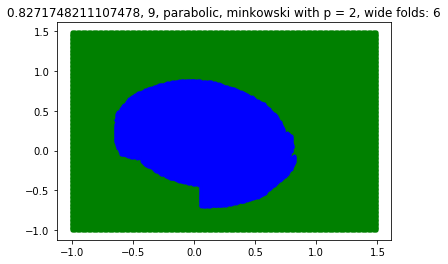

In [17]:
green = [[], []]
blue = [[], []]

for x in np.arange(-1, 1.5, 0.01):
    for y in np.arange(-1, 1.5, 0.01):
        predicted = predict_class(best_neighbor, best_metric, best_data[0], best_data[1], best_data[2](x, y), best_kernel)

        if (predicted == 0):
            green[0].append(x)
            green[1].append(y)
        else:
            blue[0].append(x)
            blue[1].append(y)

plt.title(best_string)
plt.plot(green[0], green[1], 'g.', blue[0], blue[1], 'b.')

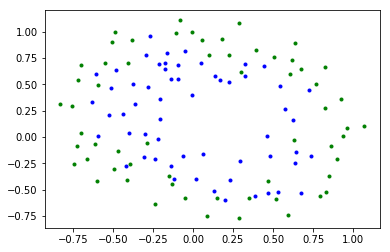

In [18]:
printAllPoints(simpleData[0], simpleData[1])

In [19]:
def get_class(x, classes):
    temp = classes[x]
    if temp == 0:
        return -1
    else:
        return 1

def lagrange(lambdas, train_suit, classes, kernel):
    result = -sum(lambdas)
    
    for i in range(len(train_suit)):
        for j in range(len(train_suit)):
            x_i = train_suit[i]
            x_j = train_suit[j]
            result += lambdas[i] * lambdas[j] * get_class(x_i, classes) * get_class(x_j, classes) * kernel(x_i, x_j)
    return result

def get_constraint(train_suit, classes):
    def constraint(x):
        result = 0
        for i in range(len(x)):
            result += get_class(train_suit[i], classes) * x[i]
        return result
    return constraint
    
def predict_svm(point, kernel, w):
    result = kernel(point, w) + w[-1]
    if result < 0:
        return 0
    return 1

# training_suit = []
# classes = {}

def SVM(data, classes, kernel, C=1, cv_params = (1, 10)):

    tfold, kfold = cv_params
    kfold_index = k_fold_cv(kfold, len(data))
    max_score = 0
    TP  = [0, 0]
    FP  = [0, 0]
    ALL = [0 , 0]
    for train_suit, test_suit in kfold_index:
        training_suit = [data[i] for i in train_suit]
        testing_suit = [data[i] for i in test_suit]
        def lagrange_gradient(x, *args):
            def dv_dxi(i):
                result = -1
                for j in range(len(x)):
                    x_i = training_suit[i]
                    x_j = training_suit[j]

                    result += x[j] * get_class(x_i, classes) * get_class(x_j, classes) * kernel(x_i, x_j)
                return result
            return [dv_dxi(i) for i in range(len(x))]


        lambdas = sopt.minimize(lagrange, 
                                np.array([0 for i in range(len(training_suit))]), 
                                (training_suit, classes, kernel), 
                                jac=lagrange_gradient, 
                                bounds=[(0,C) for i in range(len(training_suit))],
                                constraints={'type':'eq', 'fun':get_constraint(training_suit, classes)})

        w = np.array([0 for i in range(len(training_suit[0]))], dtype='float64')
        for i in range(len(training_suit)):
            lambda_i = lambdas.x[i]
            y_i = get_class(training_suit[i], classes)
            x_i = training_suit[i]
            w += np.array([lambda_i * y_i * x_i[j] for j in range(len(x_i))], dtype='float64')
        
        for point in testing_suit:
            predicted = int(predict_svm(point, kernel, w))
            real_class = int(classes[point])
            if predicted == real_class:
                TP[predicted] += 1
            else:
                FP[predicted] += 1
            ALL[real_class] += 1
        
    if TP[1] > 0:
        recall = TP[1] / ALL[1]
        precision = TP[1] / (TP[1] + FP[1])
        # F1 measure
        return 2 * (precision * recall) / (precision + recall)
    return 0

In [20]:
def simple_kernel(x, y):
    return sum(np.array(x) * np.array(y))

def square_kernel(x, y):
    return simple_kernel(x, y) ** 2

def paraboloid_kernel(x, y):
    return simple_kernel([x[0], x[1], x[0]**2 + x[1]**2], [y[0], y[1], y[0]**2 + y[1]**2])

def paraboloid_kernel2(x, y):
    return square_kernel([x[0], x[1], x[0]**2 + x[1]**2], [y[0], y[1], y[0]**2 + y[1]**2])

bikernels = [(simple_kernel, '<x,y>'),
             (square_kernel, '<x,y>^2'),
             (paraboloid_kernel, 'simple paraboloid'),
             (paraboloid_kernel2, 'square paraboloid')]

In [21]:
for kfold in [10]:
    for kernel in bikernels:
        for input_data, classes, transform_name, transform in data:
            score = SVM(input_data, classes, kernel[0], C=1, cv_params=(1,kfold))
            print(kernel[1], transform_name, score)

<x,y> - 0.39622641509433965
<x,y> x, y -> x, x + y 0.42424242424242425
<x,y> polar(0, 0) 0.03389830508474576
<x,y> polar(center_x, center_y) 0
<x,y> wide 0
<x,y>^2 - 0.6590909090909091
<x,y>^2 x, y -> x, x + y 0.6590909090909091
<x,y>^2 polar(0, 0) 0.6590909090909091
<x,y>^2 polar(center_x, center_y) 0.5466666666666666
<x,y>^2 wide 0.5806451612903226
simple paraboloid - 0.6590909090909091
simple paraboloid x, y -> x, x + y 0.6590909090909091
simple paraboloid polar(0, 0) 0.6590909090909091
simple paraboloid polar(center_x, center_y) 0.6590909090909091
simple paraboloid wide 0.6590909090909091
square paraboloid - 0.6590909090909091
square paraboloid x, y -> x, x + y 0.6590909090909091
square paraboloid polar(0, 0) 0.6395348837209303
square paraboloid polar(center_x, center_y) 0.6296296296296297
square paraboloid wide 0


In [167]:
def knn_predict_class(point, learningSet, classes, knn_k, knnMetric, knnKernel):
    distances = [(knnMetric(lpoint, point), lpoint) for lpoint in learningSet]
    distances.sort()
    d = distances[knn_k][0]
    if (d == 0):
        d = 1
    s = [0, 0]
    for j in range(knn_k):
        dist, p = distances[j]
        s[int(classes[p])] += knnKernel(dist / d)
    if (s[0] > s[1]):
        return 0
    else:
        return 1


def getKnn(learningSet, testingSet, classes, knn_k, knnMetric, knnKernel):
    result = dict()
    for point in testingSet:
        result[point] = knn_predict_class(point, learningSet, classes, knn_k, knnMetric, knnKernel)    
    return result

In [168]:
def getConfusion(pClasses):
    true_positive = [0, 0]
    false_positive = [0, 0]
    
    for point in data:
        trueClass = trueClasses[point]
        predictedClass = pClasses[point]
        
        if predicted == real_class:
            true_positive[predicted] += 1
        else:
            false_positive[predicted] += 1
    
    return (true_positive, false_negative)
    
    

def getF1Score(true_positive, false_positive):
    all_points = [0, 0]
    all_points[0] = true_positive[0] + false_positive[1]
    all_points[1] = true_positive[1] + false_positive[0]
       
    if true_positive[1] > 0:
        recall = true_positive[1] / all_points[1]
        precision = true_positive[1] / (true_positive[1] + false_positive[1])
        return 2 * (precision * recall) / (precision + recall)
    return 0

In [169]:
# H0: difference between predicted classes follows a symmetric distribution around zero
# H1: difference between predicted does not follow a symmetric distribution around zero.

# reference link: https://en.wikipedia.org/wiki/Wilcoxon_signed-rank_test

# two-sided, for one-sided count only + or - values
# Significance Level: 0.01 or 0.05?
def getWilcoxonRank(data, classes, classes1, classes2):
    diff = 0
    n = 0
    for point in data: 
        r1, r2 = 0, 0
        if (classes1[point] == classes[point]):
            r1 = 1
        if (classes2[point] == classes[point]):
            r2 = 1
            
        # diff += classes2[point] - classes1[point]
        diff += r2 - r1
        if (r2 - r1 != 0):
            n += 1
    
    diff *= (n + 1) / 2  # домножаем на ранг. все значения по модулю = 1 => ранг каждого - (1 + 2 + .. + n) / n 
    
    
    # Find the "area beyond z", using a table of areas under the normal curve 
    # It is probability to get values of W as large as ours  
    # This is the one-tailed probability of obtaining W however; 
    # so we need to multiply this probability by 2
    
    if (n > 20):
        # z_score
        mean = n * (n + 1) / 4
        sd = (n * (n + 1) * (2 * n + 1) / 24) ** 0.5
        # check
        zScore = (diff - mean) / sd
        return ('ZScore: ', zScore, n) #add table_result*2 & p
    else:
        # ok
        return ("WScore: ", diff, n)  #print table result *2 & p

In [170]:
def getCV(data, k):
    cData = data[::]
    random.shuffle(cData)
    foldSize = len(cData) // k
    folds = [cData[i * foldSize : (i + 1) * foldSize] for i in range(k)]
    q = 0
    for i in range(k * foldSize, len(cData)):
        folds[q].append(cData[i])
    return folds


def compareMethods(data, classes, k, knn_k, knnMetric, knnKernel, svmKernel):
    knnClasses = dict()
    svmClasses = dict()
    folds = getCV(data, k)
    
    for i in range(len(folds)):
        learningSet = []
        for j in range(len(folds)):
            if (j != i):
                learningSet += folds[j]
        testingSet = folds[i] 
        
        knnClasses.update(getKnn(learningSet, testingSet, classes, knn_k, knnMetric, knnKernel))
        svmClasses.update(getKnn(learningSet, testingSet, classes, knn_k + 2, knnMetric, knnKernel))
        
        #svmClasses.update(getSvm(learningSet, testingSet, classes, svmKernel))
        
    return (knnClasses, svmClasses)

In [171]:
#(data, classes, name, transform) for every in data = [simpleData, sumData, polarData, polarData2, wideData]

for d, classes, name, tr in data[:1]:
    # knnClasses, svmClasses = compareMethods(data, classes, k, knn_k, knnMetric, knnKernel, svmKernel)
    knnClasses, svmClasses = compareMethods(d, classes, 6, 4, lambda x, y: minkowskiDistance(x, y, 2), lambda x: 3 / 4 * (1 - x * x), 0)
    print(len(classes), len(knnClasses))
    wr = getWilcoxonRank(d, classes, knnClasses, svmClasses)
    print(wr)

# можно еще f1-score и confusion-matrix посчитать
# tp, fp = getConfusion(predictedClasses)
# f1 = getF1Score((tp, fp))

118 118
('WScore: ', -2.0, 3)
